<a href="https://colab.research.google.com/github/mohsenMahmoodzadeh/Image-Caption-classification-with-tensorflow-Keras/blob/master/Phase_01_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -U tensorflow-text
# !pip install tf-models-official
# !pip install tokenization
# !pip install tf-nightly

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [2]:
import os
import shutil

import tensorflow as tf
import numpy as np
# import tensorflow_hub as hub
# import tensorflow_text as text
# import tokenization
# from official.nlp import optimization  # to create AdamW optimizer
import gensim
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

## Import Datasets

In [3]:
label_map = {
    0 : 'aeroplane', 1 : 'bicycle', 2 : 'bird', 3 : 'boat', 
    4 : 'bus', 5 : 'car', 6 : 'cat', 7 : 'chair', 8 : 'cow',
    9 : 'diningtable', 10 : 'dog', 11 : 'horse', 12 : 'motorbike',
    13 : 'person', 14 : 'pottedplant', 15 : 'sheep', 16 : 'sofa',
    17 : 'train', 18 : 'tvmonitor'
  }

In [4]:
CATEGORIES = list(label_map.values())

In [5]:
TRAIN_DATA_DIR = "/content/drive/MyDrive/dataset/train/sentences/"
TEST_DATA_DIR = "/content/drive/MyDrive/dataset/test/sentences/"
CATEGORIES = ["aeroplane", "bicycle", "bird", "boat", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", 
              "motorbike", "person", "pottedplant", "sheep","sofa", "train", "tvmonitor"]

In [ ]:
def read_file(filename):
    f = open(filename, 'r')
    lines = f.readlines()
    return lines

In [ ]:
def prepare_train_data(TRAIN_DATA_DIR, CATEGORIES):
    train_data = []
    path = ""
    for category in CATEGORIES:
        temp = []
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            try:
                lines = read_file(file_path)
                for line in lines:
                    temp.append(line)

            except Exception as e:
                print(str(e))
        
        for line in temp:
            train_data.append((line, class_num))
    
    return train_data

In [ ]:
def prepare_test_data(TEST_DATA_DIR, CATEGORIES):
    test_data = []
    path = ""
    for category in CATEGORIES:
        temp = []
        path = os.path.join(TRAIN_DATA_DIR, category)
        class_num = CATEGORIES.index(category)
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            file = file_path
            try:
                lines = read_file(file)
                for line in lines:
                    temp.append(line)

            except Exception as e:
                print(str(e))
        
        for line in temp:
            test_data.append((line, class_num))
    return test_data

In [ ]:
train_data = prepare_train_data(TRAIN_DATA_DIR, CATEGORIES)

In [ ]:
test_data = prepare_test_data(TEST_DATA_DIR, CATEGORIES)

In [ ]:
data = train_data + test_data

In [ ]:
X = []
y = []
for i, sample in enumerate(data):
  X.append(sample[0])
  y.append(sample[1])

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

sentences = []

for sentence in X:
  tokens = word_tokenize(sentence)
  tokens = [w.lower() for w in tokens]
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table) for w in tokens]
  words = [word for word in stripped if word.isalpha()]
  stop_words = set(stopwords.words('english'))
  words = [w for w in words if not w in stop_words]
  sentences.append(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import gensim
w2v_model = gensim.models.Word2Vec(sentences=sentences, size = 128, window= 5, workers=4, min_count= 1)

words = list(w2v_model.wv.vocab)
print("Vocabulary size: " + str(len(words)))

Vocabulary size: 2279


In [ ]:
filename = 'w2v_embedding.txt'
w2v_model.wv.save_word2vec_format(filename, binary=False)

In [ ]:
embeddings_index = {}
f = open(os.path.join('', 'w2v_embedding.txt'), encoding='utf-8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embeddings_index[word] = coefs
f.close()

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

word_index = tokenizer.word_index
# padded_sequences = pad_sequences(sequences)

In [ ]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 128))

for word, i in word_index.items():
  if i > num_words:
    continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
print(num_words)

2280


In [7]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
seed = 1337

In [8]:
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DATA_DIR,
    batch_size = batch_size,
    label_mode="categorical",
    validation_split=0.2,
    subset='training',
    seed= seed 
)

Found 532 files belonging to 19 classes.
Using 426 files for training.


In [9]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TRAIN_DATA_DIR,
    batch_size = batch_size,
    label_mode="categorical",
    validation_split=0.2,
    subset='validation',
    seed= seed 
)

Found 532 files belonging to 19 classes.
Using 106 files for validation.


In [10]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    TEST_DATA_DIR,
    batch_size=batch_size,
    label_mode="categorical"
)

Found 380 files belonging to 19 classes.


In [11]:
print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")

Number of batches in raw_train_ds: 14
Number of batches in raw_val_ds: 4
Number of batches in raw_test_ds: 12


In [12]:
from tensorflow.keras.layers import TextVectorization
import string
import re

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, f"[{re.escape(string.punctuation)}]", ""
    )

max_features = None
embedding_dim = 128
sequence_length = 256

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    # max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [13]:
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [14]:
max_features = vectorize_layer.vocabulary_size()

In [15]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

In [16]:
train = list(train_ds)
print(train[0][0])

tf.Tensor(
[[   2 1779   28 ...    0    0    0]
 [   2  200   44 ...    0    0    0]
 [   2 1974  325 ...    0    0    0]
 ...
 [   2   14    5 ...    0    0    0]
 [   2   13    6 ...    0    0    0]
 [   2  730  116 ...    0    0    0]], shape=(32, 256), dtype=int64)


In [17]:
def create_model(max_features, embedding_dim):
    
    num_classes = 19
    
    inputs = tf.keras.Input(shape=(None,), dtype="int64")

    x = tf.keras.layers.Embedding(max_features, embedding_dim)(inputs)
    x = tf.keras.layers.SpatialDropout1D(0.5)(x)
    # x = tf.keras.layers.LSTM(64)(x)
    x = tf.keras.layers.Dense(256, activation="leaky_relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling1D()(x)

    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.5)(x)

    predictions = tf.keras.layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    model = tf.keras.Model(inputs, predictions)
    return model

In [21]:
from keras.initializers import Constant
num_classes = 19
    
inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = tf.keras.layers.Embedding(max_features, embedding_dim)(inputs)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.1,
                                                      recurrent_dropout=0.1))(x)
x = tf.keras.layers.Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv1D(32, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform")(x)
x = tf.keras.layers.BatchNormalization()(x)
# avg_pool = tf.keras.layers.GlobalAveragePooling1D()(x)
# max_pool = tf.keras.layers.GlobalMaxPooling1D()(x)
# x = tf.keras.layers.concatenate([avg_pool, max_pool])

x = tf.keras.layers.GlobalMaxPooling1D()(x)

preds = tf.keras.layers.Dense(19, activation="softmax")(x)

model = tf.keras.Model(inputs, preds)

# filters = 128
# kernel_size = 7
# lstm_units = 5
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Embedding(max_features, embedding_dim))
# # model.add(tf.keras.layers.SpatialDropout1D(0.5))
# model.add(tf.keras.layers.Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=tf.keras.regularizers.l2(0.00001), padding='same'))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
# # model.add(tf.keras.layers.SpatialDropout1D(0.5))
# model.add(tf.keras.layers.Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=tf.keras.regularizers.l2(0.00001), padding='same'))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5,return_sequences=True)))
# # model.add(tf.keras.layers.SpatialDropout1D(0.5))
# model.add(tf.keras.layers.Conv1D(filters, kernel_size=kernel_size,kernel_regularizer=tf.keras.regularizers.l2(0.00001), padding='same'))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
# model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units,dropout=0.5, recurrent_dropout=0.5)))
# model.add(tf.keras.layers.Dense(19,activation='softmax'))

In [22]:
# model = create_model(max_features, embedding_dim)
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [23]:
epochs = 30
es = tf.keras.callbacks.EarlyStopping(patience=2)
history = model.fit(train_ds, 
          validation_data= val_ds, 
          callbacks= [es],
          epochs= epochs)

Epoch 1/30
14/14 [==============================] - 30s 2s/step - loss: 3.8560 - accuracy: 0.0822 - val_loss: 2.9347 - val_accuracy: 0.0943
Epoch 2/30
14/14 [==============================] - 24s 2s/step - loss: 2.9388 - accuracy: 0.1362 - val_loss: 2.9268 - val_accuracy: 0.0755
Epoch 3/30
14/14 [==============================] - 24s 2s/step - loss: 2.4143 - accuracy: 0.3122 - val_loss: 2.9142 - val_accuracy: 0.1132
Epoch 4/30
14/14 [==============================] - 24s 2s/step - loss: 1.6568 - accuracy: 0.6056 - val_loss: 2.9043 - val_accuracy: 0.1698
Epoch 5/30
14/14 [==============================] - 24s 2s/step - loss: 0.8043 - accuracy: 0.8779 - val_loss: 2.8939 - val_accuracy: 0.1509
Epoch 6/30
14/14 [==============================] - 24s 2s/step - loss: 0.3316 - accuracy: 0.9718 - val_loss: 2.8915 - val_accuracy: 0.0660
Epoch 7/30
14/14 [==============================] - 24s 2s/step - loss: 0.1523 - accuracy: 1.0000 - val_loss: 2.8848 - val_accuracy: 0.0566
Epoch 8/30
14/14 [==

In [24]:
model.evaluate(test_ds)

12/12 [==============================] - 44s 1s/step - loss: 2.0640 - accuracy: 0.6658


[2.0640249252319336, 0.6657894849777222]

In [ ]:
# max_features = None
# embedding_dim = 128
# sequence_length = 500

In [ ]:
# vectorization_layer = \
#         tf.keras.layers.experimental.preprocessing.TextVectorization(
# #             max_tokens = max_features,
#             output_mode = "int",
#             output_sequence_length = sequence_length,
#         )

In [ ]:
# text_ds = raw_train_ds.map(lambda x, y: x)
# vectorization_layer.adapt(text_ds)

In [ ]:
# max_features = vectorization_layer.vocabulary_size()

In [ ]:
# def vectorize_text(text, label):
#     text = tf.expand_dims(text, -1)
#     return vectorization_layer(text), label

In [ ]:
# train_ds = raw_train_ds.map(vectorize_text)
# val_ds = raw_val_ds.map(vectorize_text)
# test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
# # module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
# bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

# map_name_to_handle = {
#     'bert_en_uncased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
#   }

# map_model_to_preprocess = {
#     'bert_en_uncased_L-12_H-768_A-12':
#         'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
#   }

# tfhub_handle_encoder = map_name_to_handle[bert_model_name]
# tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

Due to lack of data, we use ***Data Augmentation***.

Now Let's build a preprocessor for our data! we do it by using ***imgaug*** library. it helps us to build a custom preprocessor.
As show below, we use some transformation such as rotation, shear, Affine and some filters e.g. Flip and Gussian blur on our training data to be more robust and suitable.

In augment() function, we apply our custom preprocessor on a single image using *`preprocess_input`* method of DenseNet class.

In [ ]:
# def build_classifier_model():
#   text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
#   preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
#   encoder_inputs = preprocessing_layer(text_input)
#   encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
#   outputs = encoder(encoder_inputs)
#   net = outputs['pooled_output']
#   net = tf.keras.layers.Dropout(0.1)(net)
#   net = tf.keras.layers.Dense(len(CATEGORIES), activation='softmax', name='classifier')(net)
#   return tf.keras.Model(text_input, net)


In [ ]:
# classifier_model = build_classifier_model()

In [ ]:
# loss = tf.keras.losses.CategoricalCrossentropy()
# metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
# epochs = 30
# steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)

# init_lr = 3e-5
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')

In [ ]:
# classifier_model.compile(optimizer=optimizer,
#                          loss='categorical_crossentropy',
#                          metrics=['accuracy'])

In [ ]:
# history = classifier_model.fit(
#     x=train_ds,
#     epochs=epochs,
#     validation_data = val_ds,
#     batch_size=32,
# )

Epoch 1/30
14/14 [==============================] - 813s 57s/step - loss: 3.0020 - accuracy: 0.0540 - val_loss: 3.0152 - val_accuracy: 0.0377
Epoch 2/30
14/14 [==============================] - 799s 57s/step - loss: 3.0155 - accuracy: 0.0399 - val_loss: 3.0002 - val_accuracy: 0.0377
Epoch 3/30
14/14 [==============================] - 790s 57s/step - loss: 2.9942 - accuracy: 0.0563 - val_loss: 2.9917 - val_accuracy: 0.0377
Epoch 4/30
14/14 [==============================] - 780s 56s/step - loss: 2.9608 - accuracy: 0.0423 - val_loss: 3.0530 - val_accuracy: 0.0377
Epoch 5/30
14/14 [==============================] - 786s 56s/step - loss: 3.0000 - accuracy: 0.0587 - val_loss: 3.0228 - val_accuracy: 0.0189
Epoch 6/30
 2/14 [===>..........................] - ETA: 10:49 - loss: 3.0568 - accuracy: 0.0625

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training and validation loss')

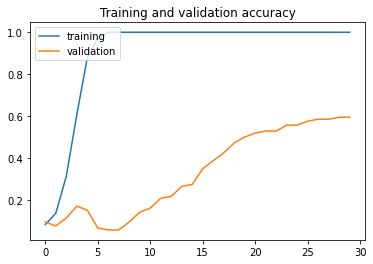

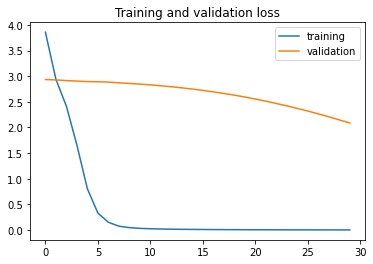

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
# from transformers import TFBertForSequenceClassification
# learning_rate = 2e-5
# epochs = 10

# model = TFBertForSequenceClassification.from_pretrained(
#         MODEL_NAME,
#         num_labels= len(CATEGORIES),
#         proxies={'http': 'foo.bar:3128', 'http://hostname': 'foo.bar:4012'}
#     )
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# metric = tf.keras.metrics.CategoricalAccuracy('accuracy')
# model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
# # tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)

In [ ]:
# bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded)
# bert_history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')